# A Practical Guide for the Efficient Formulation and Calibration of Large, Energy Rule-Based Models of Cellular Signal Transduction

# Abstract

Aberrant signal transduction leads to complex diseases such as cancer. To rationally design treatment strategies with small molecule inhibitors, computational models have to be employed. Energy Rule-based models allow the construction of mechanistic ordinary differential equation models based on structural insights. The detailed, energy-based decription often generates large models, which are difficult to calibrate on experimental data. In this chapter, we provide a detailed, interactive protocol for the programmatic formulation and calibration of such large, energy rule-based models of cellular signal transduction.

# Introduction

Cells use signal transduction to respond to extracellular cues, controlling a variety of different cellular processes such as proliferation, development and environmental adaption <cite data-cite="2754712/YK9CS8BY"></cite>. Signal transduction is initiated by the binding of extracellular ligands bind to transmembrane receptors <cite data-cite="2754712/QR4JIKLV"></cite> and then propagated through phosphorylation cascades <cite data-cite="2754712/B6ZP8LH6"></cite> <cite data-cite="2754712/NPR437GQ"></cite>, ultimately controlling gene expression through modulation of transcription factor activity. Mutations and changes in protein expression levels can dysregulate signal transduction leading to a variety of different diseases such as cancer <cite data-cite="2754712/L8NRTXRQ"></cite>. Small molecule inhibitors can be used to target specific proteins that participate in aberrant signal transduction <cite data-cite="2754712/7ZXBI6XG"></cite>. However, feedback mechanisms and cross-talk between signaling cascades, which are ubiquitous to cellular signal transduction lead to complex, non-linear responses to drug inhibition <cite data-cite="2754712/URVR5RD5"></cite>, making it difficult to anticipate the phenotypic response or resistance to these inhibitors. Accordingly, computational models that describe signal transduction including the effect of drug perturbations are required for the rational selection and dosage of targeted inhibitors <cite data-cite="2754712/DUK5BLQ4"></cite>. Mechanistic computational models of cellular signal transduction translate biological knowledge into executable mathematical formulations <cite data-cite="2754712/6JVZVNVK"></cite>. To this end, ordinary differential equations (ODE) models are attractive model formats as they can describe temporal dynamics and feedback mechanisms <cite data-cite="2754712/X784IDZJ"></cite>. Moreover, state variables and parameters correspond to biophysical entities, facilitating a direct interpretation of model simulations and predictions.

Formulation of such models is often a long labour intensive process, especially for large models. Instead of directly writing model equations, which can be tedious and error-prone, it is, thus, advisable to use some kind of abstraction when writing models. For example, the Systems Biology Markup Language (SBML) <cite data-cite="2754712/NF7FZULE"></cite> encodes models using concepts such as reactions and events, which can then be translated in to differential equation models. Rule based formats such as Kappa <cite data-cite="2754712/NAKF6985"></cite> or BioNetGen <cite data-cite="2754712/M82A4YPP"></cite> employ even higher levels of abstractions through rules, which are generalizations of reactions <cite data-cite="2754712/MIF24GAE"></cite>. While such abstractions limit the space of possible models, they also permit a more compact model description. A recent extension to rule based models are energy rule-based models <cite data-cite="2754712/6CAKFQQP"></cite> <cite data-cite="2754712/QTNJGKHE"></cite>, which provide an additional layer of abstraction, by specifying reaction rates in terms of energies. Conceptually, energies permit the theoretically sound formulation of reaction rates based on linear transition theory and provides a rigorous way of specifying context dependent reaction rates based on structural insights <cite data-cite="2754712/7TJH2IAK"></cite> <cite data-cite="2754712/DI7IDWLV"></cite>. Practically, energy based models enforce thermodynamic constraints such as the lewis-wegscheider cycle conditions <cite data-cite="2754712/VAJ8A9TA"></cite>, which ensure the conservation of energy in oligomerization process. This is particularly relevant for the specification of context dependent inhibitor affinities. For example, many RAF inhibitors have different affinities for RAF monomers and dimers, which is responsible for the clinically observed phenomenon of "paradoxical activation" <cite data-cite="2754712/68C3KR4X"></cite> <cite data-cite="2754712/GPZDY42G"></cite> <cite data-cite="2754712/46UNKAAD"></cite>.

Moreover, model calibration can be challenging for large models. During model calibration, parameter values are tuned such that model simulations agree with experimental data, which improves the predictive performance of models. Agreement between model simulations and experimental can be quantified using likelihood-based objective functions, in which case model calibration can be implemted through minimization of the respective objective function. For larger models, gradient-based optimization methods are known to perform well <cite data-cite="2754712/INKV577L"></cite>. However, for non-linear models, analytical solutions to model equations are rarely available, which means that numerical integration is necessary for evaluation of the objective function and its derivatives. Gradient-based methods not only require integration of model equations, but also model sensitivities, which quantify the dependence of simulations on model parameters. For large models, adjoint sensitivity analysis is an effective way of computing these sensitivities, but also comes with it's drawbacks such as not permitting the computation of cheap approximations to the second order derivative which could boost optimizer efficiency <cite data-cite="2754712/MKPQ9727"></cite>.

Model formulation and calibration for large models can be a challenging task <cite data-cite="2754712/C7C8DJNE"></cite>, even when using specialized software tools. Input Formats such as SBML or PEtab <cite data-cite="2754712/86CV69R2"></cite> permit the standardized problem formulation, which allows the automation of the majority of steps. However, manual interventions are still occasionally necessary to achieve optimal performance. Fixing these issues often requires substantial practical experience as well as theoretical background knowledge, which means that successful development and application of large models is often not possible without guidance from experts. To rectify this situation we here provide a detailed step-by-step protocol for the calibration of a large scale model introduced in <cite data-cite="2754712/I4JQ4DMV"></cite>. In contrast to previous protocols for ODE model calibrations <cite data-cite="2754712/3DK88XY2"></cite><cite data-cite="2754712/WCVMC7CZ"></cite><cite data-cite="2754712/D7NTVFNN"></cite><cite data-cite="2754712/RFM5WDSL"></cite><cite data-cite="2754712/S5LTETKT"></cite><cite data-cite="2754712/HWVK2XI8"></cite><cite data-cite="2754712/5ZMDTVIQ"></cite><cite data-cite="2754712/Y2DU9IB4"></cite><cite data-cite="2754712/5SLVJFMG"></cite>, this protocol puts an emphasis on large scale models of intracellular signaling, focuses on practical aspects and includes executable code. As in other protocols, theoretical background is provided when appropriate. As  protocols and reviews that provide more details about additional analysis steps including identifiability, uncertainty analysis or model selection <cite data-cite="2754712/SP36R7LH"></cite></cite><cite data-cite="2754712/HHEWVKQL"></cite><cite data-cite="2754712/NDTJEJ2U"></cite> . The protocol uses the python toolboxes PySB <cite data-cite="2754712/7D6BBY4A"></cite>, PEtab <cite data-cite="2754712/86CV69R2"></cite>, AMICI <cite data-cite="2754712/HBAI2XHJ"></cite>, pyPESTO and fides <cite data-cite="2754712/RUR9I9SQ"></cite> and is accompanied by a jupyter notebook that permits the interactive reproduction of results.

# Mathematical Problem Formulation

$\newcommand{\dims}[1]{{n_{#1}}}$ For ODE models, the temporal evolution of abundances of $\dims{x}$ different molecular species $x_i$. The temporal evolution of $\textbf{x}$ is determined by the vector field $f$ and the initial condition $\textbf{x}_0$:

\begin{equation}
\dot{\textbf{x}}=\textbf{f}(t,\textbf{x},\boldsymbol{\eta}),\quad \textbf{x}(t_0) = \textbf{x}_0(\boldsymbol{\gamma}).
\label{eq:ode}
\end{equation}

Both $\textbf{f}$ and $\textbf{x}_0$ may depend on dynamic parameters $\boldsymbol{\gamma}$, which may include kinetic parameters such as catalytic or binding rates or condition parameters such as ligand or drug concentrations.

Calibration is performed by comparing model simulations, i.e., solutions $\textbf{x}$ that satisfy $\eqref{eq:ode}$, to experimental data $\bar{\textbf{y}}$. As direct measurement of $\textbf{x}$ is usually experimentally not possible, observables

\begin{equation}
\textbf{y}(t,\boldsymbol{\gamma},\boldsymbol{\xi}) = \textbf{g}(\textbf{x}(t,\boldsymbol{\gamma}),\boldsymbol{\xi})
\label{eq:observable}
\end{equation}

are introduced, which may depend on abundances $\textbf{x}$ as well as observable parameters $\boldsymbol{\xi}$ such as scaling parameters or offsets. The agreement between model observables $\textbf{y}$ and experimental measurements $\bar{\textbf{y}}$ can be quantified according to the assumed noise model. A common assumption is that the measurement noise for $\dims{y}$ observables $y_i$ is additive and independent, normally distributed:

\begin{equation}
\bar{y}_{i} = y_i(t,\boldsymbol{\gamma},\boldsymbol{\xi}) + \epsilon_{i}, \quad \epsilon_{i} \overset{id}{\sim} \mathcal{N}(0,\sigma_{i}^2(\boldsymbol{\psi}))
\label{eq:noise}
\end{equation}

where $\boldsymbol{\psi}$ are noise parameters that encode the standard deviations $\boldsymbol{\sigma}$. Using this noise model, the negative log-likelihood 

\begin{equation}
\begin{aligned}
J(\boldsymbol{\theta}) =&  \frac{1}{2} \sum_{i=k}^\dims{k} \sum_{(i,j) \in T_k} \log\left(2\pi\sigma_{i}^2(\boldsymbol{\Psi}_{ijk}(\boldsymbol{\theta}))\right) + \left(\frac{\bar{y}_{ijk} - y_{i}(t_j,\boldsymbol{\Gamma}_k(\boldsymbol{\theta}),\boldsymbol{\Xi}_{ijk}(\boldsymbol{\theta}))}{\sigma_{i}(\boldsymbol{\Psi}_{ijk}(\boldsymbol{\theta}))}\right)^2
\label{eq:objective}
\end{aligned}
\end{equation}

statistically rigorously quantifies the agreement between experimental data and model simulations, where $\boldsymbol{\theta}$ are the free, unknown parameters, $T_k$ is the set of timepoint $t_j$, observable $y_i$ index combinations that were measured in the $k$-th out of $\dims{k}$ experimental conditions, $\boldsymbol{\Psi}_{ijk}$ is a function that maps free parameters $\boldsymbol{\theta}$ to observable, timepoint and condition specific noise parameters $\boldsymbol{\psi}$, $\boldsymbol{\Xi}_{ijk}$ is a function that maps free parameters $\boldsymbol{\theta}$ to observable, timepoint and condition specific observable parameters $\boldsymbol{\xi}$ and $\boldsymbol{\Gamma_{k}}$ is a function that maps free parameters $\boldsymbol{\theta}$ to condition specific dynamic parameters $\boldsymbol{\gamma}$ . As the logarithm is a strictly monotonously increasing function, the minimization of $ J(\boldsymbol{\theta})$ is equivalent to the maximization of the likelihood. Therefore, the corresponding minimization problem

\begin{equation}
\boldsymbol{\theta}^* = \arg \min_{\boldsymbol{\theta} \in \Theta} J(\boldsymbol{\theta}),
\label{eq:mle}
\end{equation}

 will infer the Maximum Likelihood Estimate $\boldsymbol{\theta}^*$ for parameters $\boldsymbol{\theta}$, where the search domain $\Theta\subset{\mathbb{R}}^{\dims{\theta}}$ restricts the free parameters $\boldsymbol{\theta}$ to values that are biologically reasonable and prevent numerical integration failures. For most problems, $\Theta$ is chosen as tensor product of scalar search domains $(\mathcal{L}_l,\mathcal{U}_l)$ with $\mathcal{L}_l < \mathcal{U}_l $ and $\mathcal{L}_l, \mathcal{U}_l \in \mathbb{R}\cup\{-\infty,\infty\}$ for every parameter $\theta_l$.

# Formulating a Thermodynamic Model of RAF inhibition in PySB

In the following, we will specify the model, which in turn defines the right hand side $\textbf{f}$ and the initial conditions $\textbf{x}_0$ of the model equations. We will specify the model using the rule-based modeling framework PySB, which instead of direct specification of $\textbf{f}$, programmatically encodes model structure in a modular, object oriented way ensuring reusability, composability and extendability of models <cite data-cite="2754712/7D6BBY4A"></cite>. To start model specification, we instantiate a PySB [`Model`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Model) with name `thermo_raf`.

In [1]:
from pysb import Model
model = Model('thermo_raf');

## Protein Species
As first step of the model construction, we have to define all molecules that we want to account for. In PySB, this is done by using the `Monomer` class. Each monomer is initialized by a unique identifier, a list of site as well as, optionally, a list of states for each site. Sites typically correspond to binding domains or residues that can be mutated or modified post-translationally. All sites, independent of whether possible states were specified or not, can form a bond with another site, permitting the description of complex formation.

Here, we we will define monomers `BRAF` and `CRAF` which both feature the interaction sites `RBD` (interaction domain with RAS), `mek` (interaction domain with MEK), `raf` (dimerization domain) and `rafi` (inhibitor binding site). For BRAF we also add a mutation sites for the 600th amino acid, which can take values `V` (valine, wildtype) or `E` (glutamic acid, oncogenic mutation).

In [2]:
from pysb import Monomer
Monomer('BRAF', ['AA600', 'RBD', 'mek', 'raf', 'rafi'], {'AA600': ['E', 'V']})
Monomer('CRAF', ['RBD', 'mek', 'raf', 'rafi']);

Next, we will specify initial concentrations. For this model, the concentration of all molecular species will be in $\mu\mathrm{M}$. However, we will use protein counts per cell derived from absolute proteomics to inform initial conditions. Accordingly, parameters that define initial concentrations have to be transformed from molecule per cell to $\mu\mathrm{M}$, which is achieved by dividing them by cell volume (here assumed to be $1pL = 10^{-12} L$) and the Avogadro constant ($6.022 10^{23}$ molecules) and multiplying with $10^{6}$ to account for the unit prefix $\mu$.

In the following code, we first introduce two PySB [`Expressions`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Expression) that define the avogadro constant and cell volume. PySB automatically creates workspace variables with the respective identifier, the first argument in the constructor call, which can then later be used as argument to functions or as part of more complex expressions. Next, we introduce two dynamic parameters ($\boldsymbol{\gamma}$, see $\eqref{eq:ode}$) as PySB [`Parameter`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Parameter)s `BRAF_0` and `CRAF_0` that define initial abundances as molecules per cell and convert these abundances to concentrations in $\mu\mathrm{M}$ using the expressions `initBRAF` and `initCRAF`. These expressions are then used to define the initial abundances for the two monomer species `CRAF` and `BRAF` using the PySB [`Initial`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Initial) class, which specifies $\textbf{x}_0$ for the respective molecular species $x_i$. In PySB, a molecular species is defined by a pattern, which is created by invoking the respective monomer with the state of each site as keyword argument. For initial conditions, the respective patterns have to be explicit, i.e., the states of all stites have to specified. Here, we specify that all sites are unbound (denoted by `None`), with the exception of the the `AA600` site. For the `AA600` we have to pick ony of the previously specified states, where we pick the oncogenic variant denoted by `E`. For all molecular species without an explicit instantiation of [`Initial`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Initial), the respective entry in $\textbf{x}_0$ is set to $0$.

In [3]:
from pysb import Parameter, Expression, Initial
import sympy as sp

# define Avogadro constant and volume as hardcoded expressions
Expression('N_Avogadro', sp.Float(6.02214076e+23))
Expression('volume', sp.Float(1e-12))

# define initial abundance parameters 
Parameter('BRAF_0', 0.0)
Parameter('CRAF_0', 0.0)

# convert initial abundances to concentrations
Expression('initBRAF', 1000000.0*BRAF_0/(N_Avogadro*volume))
Expression('initCRAF', 1000000.0*CRAF_0/(N_Avogadro*volume))

# define initial molecular species
Initial(BRAF(AA600='E', RBD=None, mek=None, raf=None, rafi=None), initBRAF)
Initial(CRAF(RBD=None, mek=None, raf=None, rafi=None), initCRAF);

## Protein Interactions
In rule-based modeling, all dynamic interactions are specified as rules. PySB [`Rule`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Rule)s are generalizations of biochemical reactions and their action is defined by a reactant pattern and a product pattern. When applied to a molecular species, the action of the rule, i.e., the respective biochemical reaction, is implemented by replacing one occurence of the reactant pattern by the product pattern in a molecular species. The reactant pattern and product pattern do not have to be explicit and a single rule can define multiple different biochemical reactions, depending in how often and in how many molecular species the reactant pattern occurs.

Non-thermodynamic rules additionally require forward $k_f$ and, if applicable, reverse reaction rates $k_r$. In contrast, thermodynamic rules are specified in terms of activation energy $E_a$ and the phenomenological constant $\phi$, the convex combination parameter which encodes how much changes in free energy affect forwards and reverse rates. For thermodynamic rules, the reaction rate also depends the free energy difference between to reactants and products of the reaction. This is implemented by computing forward $k_f$ and reverse $k_r$ reaction rates using the Arrhenius theory of reaction rates

$$k_f=\exp( - (E_a + \phi \Delta G)), \quad k_r=\exp( - (E_a + (\phi - 1) \Delta G))$$

with 

$$\Delta G = - \sum_{r \in R} \Delta \Delta G_r + \sum_{p \in P} \Delta \Delta G_p$$

where $E_a$ is the activation energy of the reaction, i.e., the free energy difference between the reactant state and the transition state, $\Delta G$ is the free energy difference between the reactant and the product states  and $\Delta \Delta G_r$ and $\Delta \Delta G_p$ are the free energy modifiers that apply to the reactants in $R$ and the products in $P$ respectively. The $\Delta \Delta G_r$ and $\Delta \Delta G_p$ can be specified by using the PySB `EnergyPattern` class. When calculating reaciton rates, eBNG not only accounts for EnergyPatterns that apply to the reactant and product patterns specified in the rule, but also those EnergyPatterns that specifally apply to reactant and product species. Thus, `EnergyPattern`s provide a systematic approach to specify context dependent reaction rates, which in the case of non-thermodynamic rules could only be achieved through the use of local functions.

In the following we will specify the dimerization of RAF molecules. We introduce three parameters, the activation energy for the binding reaction $E_a$ (Ea suffix), the Gibb's free energy of the formed bond $\Delta G$ (dG suffix), and the thermodynamic parameter $\phi$ (phi suffix).

In [4]:
Parameter('bind_RAF_RAF_Ea', 10.0)
Parameter('bind_RAF_RAF_dG', 0.01)
Parameter('bind_RAF_RAF_phi', 1.0);

To enforce that the actication energy $E_a = - \log(k_f)$ encodes the forward reaction rate and $\Delta G = - \log(K) = -\log \left(\frac{k_r}{k_f}\right)$ encodes the affinity constant $K$ we will pass a specially crafted custom activation energy $E_{a0} = - \phi \Delta G - E_a$, for which we create a custom expression. To then construct homo- and heterodimerization rules for all RAF paralogs, we use itertools to loop over all combinations of BRAF and CRAF, assuming equal affinities and dynamics for all proteins. For every rule we pass the custom energy $Ea_0$ and then specify an `EnergyPattern` for the single product pattern (`pp`) with $\Delta \Delta G_p = \Delta G$.

In [5]:
from pysb import Rule, EnergyPattern
import itertools as itt

Expression('Ea0_bind_RAF_RAF', 
           -bind_RAF_RAF_phi*bind_RAF_RAF_dG - bind_RAF_RAF_Ea);

for RAF1, RAF2 in itt.combinations_with_replacement([BRAF, CRAF], 2):
    pp = RAF1(raf=1) % RAF2(raf=1)
    Rule(f'{RAF1.name}_and_{RAF2.name}_bind_and_dissociate', 
         RAF1(raf=None) + RAF2(raf=None) | pp, 
         bind_RAF_RAF_phi, Ea0_bind_RAF_RAF, energy=True)
    EnergyPattern(f'ep_bind_{RAF1.name}_{RAF2.name}', pp, bind_RAF_RAF_dG);

## RAF inhibitor
Here we introduce a RAF inhibitor RAFi. We assume that the inhibitor is added to the cell medium at some point and quickly diffuses in and out of the cell. As extracellular space is much bigger than the volume of a cell, we can assume an infinite reservoir of molecules on the outside and assume that the intracellular inhibitors concentration will be unaffected by intracellular reactions. Accordingly, we specify the respective initial as constant, which means that the respective molecular species can participate in reactions, but it's concentration will remain constant.

In [6]:
Monomer('RAFi', ['raf'])

Initial(RAFi(raf=None), Parameter('RAFi_0', 0.0), fixed=True);

Next we define binding reactions for RAFi with both BRAF and CRAF, again assuming the same affinities and activation energies for both reactions.

In [7]:
Parameter('bind_RAFi_RAF_Ea', 10.0)
Parameter('bind_RAFi_RAF_dG', 0.01)
Parameter('bind_RAFi_RAF_phi', 1.0)
Expression('Ea0_bind_RAFi_RAF', 
           -bind_RAFi_RAF_phi*bind_RAFi_RAF_dG - bind_RAFi_RAF_Ea)

for RAF in [BRAF, CRAF]:
    Rule(f'RAFi_and_{RAF.name}_bind_and_dissociate', 
         RAFi(raf=None) + RAF(rafi=None) | RAFi(raf=1) % RAF(rafi=1), 
         bind_RAFi_RAF_phi, Ea0_bind_RAFi_RAF, energy=True)
    EnergyPattern(f'ep_bind_{RAF.name}_RAFi', 
                  RAFi(raf=1) % RAF(rafi=1), bind_RAFi_RAF_dG);

## Paradoxical Activation
RAF inhibitors inhibit growth for BRAF mutants but promote growth for NRAS mutants. At the strucural level, this can be rationalized by assuming that RAF inhibitors have higher affinity towards drug-unbound RAF dimers and lower affinity towards drug bound RAF dimers. The symmetry, conveyed by energy conservation of molecular binding reactions, implies that RAF inhibitors, at low to medium concentrations, promote dimerization but incompletely inhibit signaling as they only bind to one of the two protomers in a dimer. As MAPK signaling in NRAS mutant cells is mediated by RAF dimers, respective signaling is amplified, leading to increased growth. In the thermodynamic models, this can be implemented by specifying additional `EnergyPattern`s  that controls the Gibbs free energy of RAF-RAF-RAFi trimers. Note that we do not specify how these trimers are formed, so the change in energy will equally apply to the rates of all reactions that either consume or produce these trimers. In this example, an decrease in energy would equally increase RAF dimerization and inhbitor binding, thus implementing the previously described symmetry.

In [8]:
Parameter('ep_RAF_RAF_RAFi_ddG', 0.001)
for RAF1, RAF2 in itt.product([BRAF, CRAF], repeat=2):
    EnergyPattern(
        f'ep_{RAF1.name}_{RAF2.name}_mod_RAFi_single', 
        RAF1(raf=1, rafi=None) % RAF2(raf=1, rafi=2) % RAFi(raf=2), 
        ep_RAF_RAF_RAFi_ddG);

To implement the protection of the second dimer, we add an additional `EnergyPattern` that changes the Gibbs free energy of RAFi-RAF-RAF-RAFi quatramers.

In [9]:
Parameter('ep_RAF_RAF_RAFi_RAFi_ddG', 1000.0)
for RAF1, RAF2 in itt.combinations_with_replacement([BRAF, CRAF], r=2):
    EnergyPattern(
        f'ep_{RAF1.name}_{RAF2.name}_mod_RAFi_double', 
        RAFi(raf=2) % RAF1(raf=1, rafi=2) % RAF2(raf=1, rafi=3) % RAFi(raf=3), 
        ep_RAF_RAF_RAFi_RAFi_ddG);

Here we note that these `EnergyPattern`s only specify that changes in affinity are permissible in the model. The nature of these changes has to be encoded in their values, where negative values lead to stabilization and positive values to destabilization of respective complexes.

We will now load the remainder of the model from a file. Briefly, the full model describes MEK and ERK phosphorylation downstream as well as EGF stimulatable EGFR signaling upstream of RAF signaling. Moreover, it incorporates negative feedback from ERK on both MAPK and EGFR signaling. A comprehensive description of this part of the model is available in <cite data-cite="2754712/I4JQ4DMV"></cite>. Note however, that parts of the model were substantially simplified account for the reduced set of experimental data.

In [10]:
from pysb import Observable, ANY
def extend_model():
    Monomer('RAS', ['raf', 'state'], {'state': ['gdp', 'gtp']})
    Monomer('MEK', ['phospho'], {'phospho': ['p', 'u']})
    Monomer('ERK', ['phospho'], {'phospho': ['p', 'u']})
    Monomer('DUSP', [])

    Parameter('ep_RAF_RAF_mod_RASstategtp_double_ddG', 1000.0)
    Parameter('bind_RASstategtp_RAF_Ea', 10.0)
    Parameter('bind_RASstategtp_RAF_dG', 0.01)
    Parameter('bind_RASstategtp_RAF_phi', 1.0)
    Parameter('catalyze_RAF_RAFrafiNone_MEK_p_kcat', 10.0)
    Parameter('catalyze_RAFrafiNone_MEK_p_kcat', 10.0)
    Parameter('catalyze_MEKmekiNone_phosphop_ERK_p_kcat', 10.0)
    Parameter('synthesize_ERKphosphop_DUSP_ERK_gexpslope', 1000.0)
    Parameter('synthesize_ERKphosphop_DUSP_kdeg', 10.0)
    Parameter('synthesize_ERKphosphop_DUSP_ERK_kM', 0.0)
    Parameter('inhibition_ERKphosphop_RAS_kM', 0.0)
    Parameter('catalyze_PP2A_MEK_u_kcatr', 1.0)
    Parameter('catalyze_DUSP_ERK_u_kcatr', 1.0)
    Parameter('activation_RAS_kcat', 1.0)

    Parameter('RAS_0', 0.0)
    Parameter('MEK_0', 0.0)
    Parameter('ERK_0', 0.0)
    Parameter('EGF_0', 0.0)
    Parameter('DUSP_eq', 10000.0)

    Expression('Ea0_bind_RASstategtp_BRAF', 
               -bind_RASstategtp_RAF_phi*bind_RASstategtp_RAF_dG - bind_RASstategtp_RAF_Ea)
    Expression('Ea0_bind_RASstategtp_CRAF', 
               -bind_RASstategtp_RAF_phi*bind_RASstategtp_RAF_dG - bind_RASstategtp_RAF_Ea)
    
    Expression('catalyze_PP2A_MEK_u_kcat', catalyze_PP2A_MEK_u_kcatr*catalyze_RAFrafiNone_MEK_p_kcat)
    Expression('catalyze_DUSP_ERK_u_kcat', catalyze_DUSP_ERK_u_kcatr*catalyze_MEKmekiNone_phosphop_ERK_p_kcat)

    Expression('initMEK', 1000000.0*MEK_0/(N_Avogadro*volume))
    Expression('initERK', 1000000.0*ERK_0/(N_Avogadro*volume))
    Expression('initRAS', 1000000.0*RAS_0/(N_Avogadro*volume))

    Observable('modulation_ERKphosphop', ERK(phospho='p'))

    Expression('synthesize_ERKphosphop_DUSP_ERK_kmod', modulation_ERKphosphop*synthesize_ERKphosphop_DUSP_ERK_gexpslope/(modulation_ERKphosphop + synthesize_ERKphosphop_DUSP_ERK_kM) + 1)
    Expression('synthesize_ERKphosphop_DUSP_ksyn', 1.0*DUSP_eq*synthesize_ERKphosphop_DUSP_kdeg*synthesize_ERKphosphop_DUSP_ERK_kmod)
    Expression('inhibition_ERKphosphop_RAS_kmod', activation_RAS_kcat/(1 + modulation_ERKphosphop/inhibition_ERKphosphop_RAS_kM)*EGF_0/100.0)


    Rule('RASgtp_and_BRAF_bind_and_dissociate', 
         RAS(raf=None) + BRAF(RBD=None) | 
         RAS(raf=1) % BRAF(RBD=1), 
         bind_RASstategtp_RAF_phi, Ea0_bind_RASstategtp_BRAF, energy=True)
    Rule('RASgtp_and_CRAF_bind_and_dissociate', 
         RAS(raf=None) + CRAF(RBD=None) | 
         RAS(raf=1) % CRAF(RBD=1), 
         bind_RASstategtp_RAF_phi, Ea0_bind_RASstategtp_CRAF, energy=True)
    Rule('BRAF_BRAF_phosphorylates_MEK', 
         MEK(phospho='u') + BRAF(RBD=ANY, raf=2, rafi=None) % BRAF(RBD=ANY, raf=2) >> 
         MEK(phospho='p') + BRAF(RBD=ANY, raf=2, rafi=None) % BRAF(RBD=ANY, raf=2), 
         catalyze_RAF_RAFrafiNone_MEK_p_kcat)
    Rule('CRAF_BRAF_phosphorylates_MEK', 
         MEK(phospho='u') + CRAF(RBD=ANY, raf=2, rafi=None) % BRAF(RBD=ANY, raf=2) >> 
         MEK(phospho='p') + CRAF(RBD=ANY, raf=2, rafi=None) % BRAF(RBD=ANY, raf=2), 
         catalyze_RAF_RAFrafiNone_MEK_p_kcat)
    Rule('CRAF_CRAF_phosphorylates_MEK', 
         MEK(phospho='u') + CRAF(RBD=ANY, raf=2, rafi=None) % CRAF(RBD=ANY, raf=2) >> 
         MEK(phospho='p') + CRAF(RBD=ANY, raf=2, rafi=None) % CRAF(RBD=ANY, raf=2), 
         catalyze_RAF_RAFrafiNone_MEK_p_kcat)
    Rule('BRAFV600E_phosphorylates_MEK_bound1', 
         MEK(phospho='u') + BRAF(AA600='E', raf=None, rafi=None) >> 
         MEK(phospho='p') + BRAF(AA600='E', raf=None, rafi=None), 
         catalyze_RAFrafiNone_MEK_p_kcat)
    Rule('BRAFV600E_phosphorylates_MEK_bound2', 
         MEK(phospho='u') + BRAF(AA600='E', RBD=None, raf=ANY, rafi=None) >> 
         MEK(phospho='p') + BRAF(AA600='E', RBD=None, raf=ANY, rafi=None), 
         catalyze_RAFrafiNone_MEK_p_kcat)
    Rule('BRAFV600E_phosphorylates_MEK_bound3', 
         MEK(phospho='u') + BRAF(AA600='E', RBD=ANY, raf=2, rafi=None) % BRAF(RBD=None, raf=2) >>
         MEK(phospho='p') + BRAF(AA600='E', RBD=ANY, raf=2, rafi=None) % BRAF(RBD=None, raf=2), 
         catalyze_RAFrafiNone_MEK_p_kcat)
    Rule('BRAFV600E_phosphorylates_MEK_bound4', 
         MEK(phospho='u') + BRAF(AA600='E', RBD=ANY, raf=2, rafi=None) % CRAF(RBD=None, raf=2) >> 
         MEK(phospho='p') + BRAF(AA600='E', RBD=ANY, raf=2, rafi=None) % CRAF(RBD=None, raf=2), 
         catalyze_RAFrafiNone_MEK_p_kcat)
    Rule('MEK_is_dephosphorylated', 
         MEK(phospho='p') >> 
         MEK(phospho='u'), catalyze_PP2A_MEK_u_kcat)
    Rule('pMEK_phosphorylates_ERK', 
         ERK(phospho='u') + MEK(phospho='p') >> 
         ERK(phospho='p') + MEK(phospho='p'), catalyze_MEKmekiNone_phosphop_ERK_p_kcat)
    Rule('DUSP_dephosphorylates_ERK', 
         ERK(phospho='p') + DUSP() >> 
         ERK(phospho='u') + DUSP(), catalyze_DUSP_ERK_u_kcat)
    Rule('synthesis_DUSP', 
         None >> DUSP(), 
         synthesize_ERKphosphop_DUSP_ksyn)
    Rule('basal_degradation_DUSP', 
         DUSP() >> None, 
         synthesize_ERKphosphop_DUSP_kdeg, delete_molecules=True)
    Rule('activation_RAS', 
         RAS(state='gdp') | RAS(state='gtp'), 
         inhibition_ERKphosphop_RAS_kmod, activation_RAS_kcat)

    EnergyPattern('ep_BRAF_BRAF_mod_RAS_double', RAS(raf=2, state='gtp') % BRAF(RBD=2, raf=1) % BRAF(RBD=3, raf=1) % RAS(raf=3, state='gtp'), ep_RAF_RAF_mod_RASstategtp_double_ddG)
    EnergyPattern('ep_BRAF_CRAF_mod_RAS_double', RAS(raf=2, state='gtp') % BRAF(RBD=2, raf=1) % CRAF(RBD=3, raf=1) % RAS(raf=3, state='gtp'), ep_RAF_RAF_mod_RASstategtp_double_ddG)
    EnergyPattern('ep_CRAF_CRAF_mod_RAS_double', RAS(raf=2, state='gtp') % CRAF(RBD=2, raf=1) % CRAF(RBD=3, raf=1) % RAS(raf=3, state='gtp'), ep_RAF_RAF_mod_RASstategtp_double_ddG)
    EnergyPattern('ep_bind_RASstategtp_BRAF', RAS(raf=1, state='gtp') % BRAF(RBD=1), bind_RASstategtp_RAF_dG)
    EnergyPattern('ep_bind_RASstategtp_CRAF', RAS(raf=1, state='gtp') % CRAF(RBD=1), bind_RASstategtp_RAF_dG)

    Initial(RAS(raf=None, state='gdp'), initRAS)
    Initial(MEK(phospho='u'), initMEK)
    Initial(ERK(phospho='u'), initERK)

extend_model();

# Importing data in PEtab Format

With the model at hand, the next step for model calibration is specification of the objective function $\eqref{eq:objective}$. We will specify the objective function using PEtab<cite data-cite="2754712/86CV69R2"></cite>, which simplifies the definition of multiple experimental conditions. The petab specification of a calibration problem consists of the tables describing model observables, experimental measurements, experimental conditions and model parameters. Additionally, tables describing the visualization of simulations and data may also be included.

## Observables

We will start the PEtab definition by specifying the model observables $\textbf{y}$ (see $\eqref{eq:observable}$). Observables define the the model quantities that were measured experimentally, here pMEK and pERK. First, we add respective observables to the model using PySB [`Observable`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Observable)s:

In [11]:
Observable('pMEK_obs', MEK(phospho='p'))
Observable('pERK_obs', ERK(phospho='p'));

These observables quantify all MEK (MAP2K1 + MAP2K2) and ERK (MAPK1 + MAPK3) molecules that are phosphorylated on the site `phospho`, which accounts for phosphorylation on S218/S222 or S222/S226 on MEK and T185/Y187 or T202/Y204 on ERK. These PySB [`Observable`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Observable)s define linear sums of model species $\sum_i w_i x_i$, where $w_i$ is an integer that quantifies how often the specified pattern matches the species $x_i$.

Next, we construct the PEtab [`observables table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#observables-table) The model quantifies pMEK and pERK in concentrations, but measurements are noise corrupted, measured in fluorescence intensity and also include background fluorescence. As the scaling between concentrations and intensity and the amount of background signal is known, we include scaling and offset parameters in the PEtab observable definition `petab.OBSERVABLE_FORMULA`, which specifies the observable function $g_i$ (see $\eqref{eq:observable}$). To account for noise corruption, we specify a single noise parameter $\psi_i$ as PEtab noise formula `petab.NOISE_FORMULA`, which corresponds to Gaussian noise (default when no `petab.NOISE_DISTRIBUTION` is specified) distribution, with the respective parameter as standard deviation $\sigma_i$ (see $\eqref{eq:noise}$). The prefix `noiseParameter1` indicates that the value of the parameter will be provided in the respective column of the [`measurement table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#measurement-table), which permits the specification of timepoint and condition specific noise levels via $\Psi_{ijk}$ (see $\eqref{eq:objective}$). Here, the specified observable formula $g_i$ does not include any explicit PEtab noise parameters. However, the scale and offset parameters for each observable could be replaced by `observableParameter[0-9]+` placeholders, which would enable the designation of timepoint and condition specific values in the [`measurement table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#measurement-table).

In [12]:
import petab
import pandas as pd
observables_table = pd.DataFrame([
    {
        petab.OBSERVABLE_ID: obs_id,
        petab.OBSERVABLE_FORMULA: 
            f'{obs_id}_scale*{obs_id}_obs + {obs_id}_offset',
        petab.NOISE_FORMULA: f'noiseParameter1_{obs_id}'
    } for obs_id in ['pMEK', 'pERK']
]).set_index(petab.OBSERVABLE_ID)

,observableFormula,noiseFormula
observableId,,
pMEK,pMEK_scale*pMEK_obs + pMEK_offset,noiseParameter1_pMEK
pERK,pERK_scale*pERK_obs + pERK_offset,noiseParameter1_pERK


## Measurements and Conditions
As experimental measurement, we will load one of the datasets from REF, which contains the response of A375 cells cultured for 24h at different concentrations of multiple RAF and MEK inhibitors. The response is measured as normalized phospho-MEK (pMEK) and phospho-ERK (pERK) abundances in both EGF stimulated and unstimulated cells after 5 minutes.

In [13]:
import synapseclient as sc
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 6)

syn = sc.Synapse()
syn.login(silent=True);
data_df = pd.read_csv(syn.get('syn22804081').path)

,Cell_Line,Vemurafenib,Dabrafenib,...,Std.7,Std.8,Std.9
0,A375,-1,0.0,...,0.009442,0.019582,0.007556
1,A375,-1,0.0,...,0.111256,0.079383,0.141893
...,...,...,...,...,...,...,...
54,A375,0,0.1,...,0.007028,0.018578,0.024706
55,A375,0,0.1,...,0.014206,0.046046,0.117991


The data contains the dose response to multiple RAF an MEK inhibitors as well as respective combinations. However, to minimize computation time requirements, we will only consider data involving the two RAFis vemurafenib and dabrafenib. The model itself only contains generic `RAFi` parameters and species, which we can now map to specific inhibitors using experimental conditions. This permits the simultaneous estimation of inhibitor specific kinetic rates in conjunction with all other model parameters. Such an multi-experiment setup can improve parameter identifiability. 

In the following, we will simulatenously generate the [`condition table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#condition-table), encoding the condition specific mapping $\boldsymbol{\Gamma}_k$ (see $\eqref{eq:objective}$) of dynamic paramers $\boldsymbol{\gamma}$ (see $\eqref{eq:ode}$), and [`measurement table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#measurement-table), econding measurements $\bar{\textbf{y}}
_{ijk}$ and, potentially, respective mappings for observable parameters $\boldsymbol{\xi}$ (see $\eqref{eq:observable}$) via $\boldsymbol{\Xi}_{ijk}$ (see $\eqref{eq:objective}$) and noise parameters $\boldsymbol{\psi}$ (see $\eqref{eq:noise}$) via $\boldsymbol{\Psi}_{ijk}$ (see $\eqref{eq:objective}$). The [`condition table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#condition-table) describes the necessary information about experimentel conditions, i.e., what drug was used and what concentrations were applied. The [`measurement table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#measurement-table) describes the measurement itself as well as additional information such as under which experimental conditions the data was measured.

The data we loaded above is in a matrix format, while PEtab requires the data a long format. Thus, additional processing is necessary. Briefly, the code below extracts all data points and sets what model observable they belong to, the value of the measurement, the time of measurement, the noise parameter, information about the experimental condition as well as a `petab.DATASET_ID`, which is only used for plotting.

For the EGF stimulation condition, it is important to consider the experimental setup, as cells are subjected to 24h of pretreatment with drugs. We here assume that this is sufficient time for the system to reach a steady-state. To describe such an experimental setup in PEtab, it is necessary to reference the respective experimental condition in the [`condition table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#condition-table) by specifying the respective `petab.CONDITION_ID` in the `petab.PREEQUILIBRATION_CONDITION_ID` column. The condition for the actual experiment can then be specified in the `petab.SIMULATION_CONDITION_ID`.

To enable the visualization of data and fitting results, we here also specify the `petab.DATASET_ID`. Contrary to what the name may suggests, this does not influence the actual fitting, but serves as grouping identifier during plotting.

In [14]:
RAFis = ['Vemurafenib', 'Dabrafenib', 'PLX8394', 'LY3009120', 'AZ_628']
MEKis = ['Cobimetinib', 'Trametinib', 'Selumetinib', 'Binimetinib', 'PD0325901']


conditions = dict()


def format_petab(row):
    suffixes = [''] + [f'.{idx}' for idx in range(1,10)]
    datapoints = []
    if row[MEKis].any():
        return datapoints
    # loop over columns of the data matrix
    for suffix in suffixes:
        # extract data
        datapoint = {
            petab.OBSERVABLE_ID: 'pMEK' if row.pMEK else 'pERK',
            petab.MEASUREMENT: row[f'Mean{suffix}'],
            petab.TIME: row['Time_EGF'],
            petab.NOISE_PARAMETERS: row[f'Std{suffix}'],
        }
        # extract condition information
        if (row[RAFis] != 0).sum() != 1 or \
                ((row['Vemurafenib'] == 0) and (row['Dabrafenib'] == 0)):
            continue

        # find first nonzero
        rafi = RAFis[(row[RAFis] != 0).argmax()]

        # extract drug concentration
        drug_conc = row[f'Concentration (uM){suffix}'] if row[rafi] == -1 \
            else row[rafi]
        # condition id must be sanitzed, must match '^[a-zA-Z]+[\w_]*$'
        drug_str = f'{rafi}_{drug_conc}'.replace('.', '_').replace('-', '_')

        condition_str = drug_str + (
            f'__EGF_{row["EGF"]}' if row['EGF'] > 0 else ''
        )
        condition = {
            petab.CONDITION_ID: condition_str,'RAFi_0': drug_conc,
            'EGF_0': row["EGF"], 'bind_RAFi_RAF_Ea': f'bind_{rafi}_RAF_Ea',
            'bind_RAFi_RAF_dG': f'bind_{rafi}_RAF_dG',
            'ep_RAF_RAF_RAFi_ddG': f'ep_RAF_RAF_{rafi}_ddG',
            'ep_RAF_RAF_RAFi_RAFi_ddG': f'ep_RAF_RAF_{rafi}_{rafi}_ddG'
        }
        # set baseline for datapoint
        datapoint[petab.PREEQUILIBRATION_CONDITION_ID] = drug_str
        # set id for condition and datapoint
        datapoint[petab.SIMULATION_CONDITION_ID] = condition_str
        datapoint[petab.DATASET_ID] =  ('EGF__' if row['EGF'] > 0 \
                                        else 'ctrl__') + rafi
        condition[petab.CONDITION_ID] = condition_str
        
        datapoints.append(datapoint)
        if condition_str not in conditions:
            conditions[condition_str] = condition
            
    return datapoints

measurement_table = pd.DataFrame([
    d
    for ir, row in data_df.iterrows()
    for d in format_petab(row)
])
condition_table = pd.DataFrame(conditions.values()).set_index(petab.CONDITION_ID);

In the above code we directly used experimentally measured standard deviations, which can be noisy as they are often computed from a small number of biological or technical replicates. As the magnitude of standard deviations determines the importance of datapoints during calibration, outliers can lead to overemphasis or ignorance of individual datapoints, resulting in poor fits to the overall data. To avoid such issues, we use the same averaged standard deviations for all datapoints of each observable. For averaging we compute the root mean square, as standard deviations are not additive, while variances are.

In [15]:
import numpy as np
for group, frame in measurement_table.groupby(petab.OBSERVABLE_ID):
    measurement_table.loc[measurement_table[petab.OBSERVABLE_ID]==group, 
                          petab.NOISE_PARAMETERS] = \
        np.sqrt(frame[petab.NOISE_PARAMETERS].apply(np.square).mean())
measurement_table;

,observableId,measurement,time,...,preequilibrationConditionId,simulationConditionId,datasetId
0,pERK,0.969789,0.0833,...,Vemurafenib_0_000210819,Vemurafenib_0_000210819,ctrl__Vemurafenib
1,pERK,0.944607,0.0833,...,Vemurafenib_0_000666667,Vemurafenib_0_000666667,ctrl__Vemurafenib
...,...,...,...,...,...,...,...
78,pMEK,1.172071,0.0833,...,Dabrafenib_0_210818511,Dabrafenib_0_210818511__EGF_100,EGF__Dabrafenib
79,pMEK,1.091548,0.0833,...,Dabrafenib_0_666666667,Dabrafenib_0_666666667__EGF_100,EGF__Dabrafenib


## Parameters
The last table necessary for model training is the [`parameter table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#parameter-table). This table describes all free parameters $\boldsymbol{\theta}$, whether they have to be estimated as well as, parameter scale, nominal values, boundary values $\mathcal{L}_l$ and $\mathcal{U}_l$ and information about priors.

Both parameter boundaries and priors can be used to restrict the search space to biologically plausible parameter values, or prevent numerical issues in regions of parameter space where numerical integration of model equations is challenging. Parameter boundaries set hard threshold that cannot be exceeded, while parameter boundaries are soft constraints that also regularize the calibration. While priors are necessary for Bayesian analysis such as parameter sampling, they are not generally required for optimization based approaches.

For most models, free parameters $\boldsymbol{\theta}$ will primarily occur in the model specification as dynamic parameters $\boldsymbol{\gamma}$. But, all of previously described tables may introduce new free parameters: noise parameters $\boldsymbol{\psi}$ in noise formulas $\boldsymbol{\sigma}$ or respective condition specific mappings $\boldsymbol{\Psi}_{ijk}$, observable paramers $\boldsymbol{\xi}$ in observable formulas $\boldsymbol{g}$ or respective condition specific mappings $\boldsymbol{\Xi}_{ijk}$ as well as the condition specific dynamic parameter mappings $\boldsymbol{\Gamma}_{k}$. Moreover, the respective tables, i.e., the respective mappings $\boldsymbol{\Psi}_{ijk}$, $\boldsymbol{\Xi}_{ijk}$ and $\boldsymbol{\Gamma}_{k}$ may set numerical values for the noise, observable and dynamic parameters, rendering them non-free. As the parameter table must only describe free parameters $\boldsymbol{\theta}$, some processing is usually necessary to identify free and non-free parameters.

In the following, we will construct a list of `condition_pars`, which are either mapped to free, condition-specific parameters, such as the generic RAFi energy parameters, or set to non-free parameters with fixed numeric values, such as the `RAFi_0` initial concentration. To construct the list of free parameters, we identify all dynamic parameters in the model that are not contained in these `condition_pars`, and add all newly introduced condition specific parameters in the [`condition table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#condition-table) as well as the four offset and scaling parameters we introduced in the [`observables table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#observables-table).

In [17]:
import numpy as np
condition_pars = [
    par.name
    for par in model.parameters
    if par.name in condition_table.columns
]

free_parameters = [
    par.name for par in model.parameters
    if par.name not in condition_pars
] + [
    name
    for par in condition_pars
    for name in np.unique(condition_table[par])
    if isinstance(name, str)
] + [
    'pMEK_offset','pMEK_scale', 'pERK_offset', 'pERK_scale'
]

All of the parameters in the model follow a consistent naming scheme, which makes it easier to programmatically specify parameter boundaries, scales and whether parameters are to be estimated. Multiple studies have demonstrated that parameter estimation is more efficient when estimating parmaters on a logarithmic scale <cite data-cite="2754712/INKV577L"></cite><cite data-cite="2754712/FMD3RVCR"></cite>. The thermodynamic formulation we employed for model construction relies on an exponential dependency between energies and kinetetic rates, which complements these practical insights with a theoretical foundation why model parameters live on a logarithmic scale. However, this also suggests that energetic parameters, in contrast to kinetic rates, should be estimated on a linear scale.

The upper and lower boundaries should ideally be set to biologically plausible values. However, most models employ simplified descriptions of the underlying biochemical processes, which means that model parameters may no longer have a one-to-one correspondance to true biochemical constants and plausible parameter ranges may be difficult to derive. Moreover, plausible parameter ranges may not be known for all parameters. Therefore, in many applications parameter boundaries are initially based on educated guesses and then refined based on estimation results such that optima are contained in the specified ranges and integration failures are not too frequent. Therefore, the boundaries presented here are based on the values used in the original publication and where then refined to work with the simplified model.

Similar to parameter boundaries, nominal values can be difficult to derive. However, the numerical values are only important for model calibration when respective parameters are not estimated. In this example, we do not estimate the initial concentrations and $\phi$ parameters and only set the nominal parameter values of those parameters to non-trivial values. The initial concentrations are set to approximate molecular counts as measured in the original publication and $\phi$ parameters are all set to 1, meaning that free energy differences only affect the reverse rate.


In [18]:
lbs = {
    'Ea': -8, 'dG': -8, 'ddG': -8, 'phi': 0, 'offset': 5e-2,
    'scale': 1e0, 'eq': 1e1, '0': 1e3, 'kcat': 1e-2, 'gexpslope': 1e0,
    'kdeg': 1e-3, 'kM': 1e-3, 'kcatr': 1e-5, 'koff': 1e-5,
}
ubs = {
    'Ea': 8, 'dG': 8, 'ddG': 8, 'phi': 1, 'offset': 2e-1,
    'scale': 1e6, 'eq': 1e5, '0': 1e5, 'kcat': 1e5, 'gexpslope': 1e6,
    'kdeg': 1e2, 'kM': 1e1, 'kcatr': 1e2, 'koff': 1e0,
}

initials = {
    'BRAF_0': 1e3, 'CRAF_0': 1e4, 'MEK_0': 1e5, 'ERK_0': 1e5, 'RAS_0': 5e4,
}


parameter_table = pd.DataFrame([
    {
        petab.PARAMETER_ID: par,
        petab.PARAMETER_SCALE: petab.LIN 
        if par.endswith(('_Ea', '_dG', '_ddG', '_phi')) else petab.LOG10,
        petab.LOWER_BOUND: lbs[par.split('_')[-1]],
        petab.UPPER_BOUND: ubs[par.split('_')[-1]],
        petab.NOMINAL_VALUE: initials[par] if par.endswith('_0') else 1.0,
        petab.ESTIMATE: False if par.endswith(('_phi', '_0')) else True,
        
    } for par in free_parameters
]).set_index(petab.PARAMETER_ID);

,parameterScale,lowerBound,upperBound,nominalValue,estimate
parameterId,,,,,
BRAF_0,log10,1000.00,100000.0,1000.0,False
CRAF_0,log10,1000.00,100000.0,10000.0,False
...,...,...,...,...,...
pERK_offset,log10,0.05,0.2,1.0,True
pERK_scale,log10,1.00,1000000.0,1.0,True


## SBML export
PEtab expects a model in SBML format, but we constructed the model in the pysb format. Therefore, we need to export the model in SBML format.

In [19]:
import libsbml
from pysb.export import export
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBMLFromString(export(model, 'sbml'))
sbml_model = sbml_doc.getModel()

In the SBML model, PySB [`Observable`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Observable)s are exported as SBML parameters with assignment rules, with programmatically generated identifiers that do not agree with the PySB [`Observable`](https://pysb.readthedocs.io/en/stable/modules/core.html#pysb.core.Observable) names. As we referenced these observable names when specifying the PEtab observables, we have to change the identifiers of these parameter to match the PySB names. These changes have to be applied to the SBML [`Parameter`](http://model.caltech.edu/software/libsbml/5.18.0/docs/formatted/python-api/classlibsbml_1_1_parameter.html) as well as the SBML [`AssignmentRule`](http://model.caltech.edu/software/libsbml/5.18.0/docs/formatted/python-api/classlibsbml_1_1_assignment_rule.html) that sets their value.

In [20]:
# rename pysb exported observables
sbml_model.getParameter('__obs1').setId('pMEK_obs')
sbml_model.getAssignmentRuleByVariable('__obs1').setVariable('pMEK_obs')
sbml_model.getParameter('__obs2').setId('pERK_obs')
sbml_model.getAssignmentRuleByVariable('__obs2').setVariable('pERK_obs');

As last step, we create a PEtab [`Problem`](https://petab.readthedocs.io/projects/libpetab-python/en/latest/build/_autosummary/petab.problem.html#petab.problem.Problem) using all of the previously constructed table as well as the exported SBML model. As problem construction was a lengthy, error-prone process, we perform a static analysis of the petab problem using the petab library provided linter [`petab.lint_problem`](https://petab.readthedocs.io/projects/libpetab-python/en/latest/build/_autosummary/petab.html#petab.lint_problem).

In [21]:
import petab
petab_problem = petab.Problem(
    sbml_model=sbml_model, sbml_reader=sbml_reader, sbml_document=sbml_doc,
    measurement_df=measurement_table, condition_df=condition_table,
    observable_df=observables_table, parameter_df=parameter_table
)
petab.lint.lint_problem(petab_problem);

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s6' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s7' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initial

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s22' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s23' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s38' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s39' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s54' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s55' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s70' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s71' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s86' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s87' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s10' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s11' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s26' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s27' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s42' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s43' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s58' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s59' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s74' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s75' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s90' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initialAssignment> or <assignmentRule>.

libSBML Warning (Modeling practice): As a principle of best modeling practice, the <species> should set an initial value (amount or concentration) rather than be left undefined. Doing so improves the portability of models between different simulation and analysis systems, and helps make it easier to detect potential errors in models.
 The <species> with the id '__s91' does not have an 'initialConcentration' or 'initialAmount' attribute, nor is its initial value set by an <initi

# Calibrating the model in pyPESTO
Model calibration based on PEtab <cite data-cite="2754712/86CV69R2"></cite> format is supported by a growing number of tools including COPASI <cite data-cite="2754712/I9T5NNAF"></cite> and data2dynamics <cite data-cite="2754712/RYRYBYZA"></cite>. Here we used the python based calibration tool pyPESTO for calibration. pyPESTO uses AMICI <cite data-cite="2754712/HBAI2XHJ"></cite> for model import and simulation, constructs functions to evaluate the objective function $J(\boldsymbol{\theta})$ and it's gradient $\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$ and provides an interface to a plethora of optimizers. 

To facilitate efficient evaluation of the objective function and it's derivatives, we will first compile the model in AMICI. Model compilation should take about a minute on modern desktop machines, but ensures that numerical solutions $\textbf{x}$ and their sensitivies $\nabla_{\boldsymbol{\eta}}\textbf{x}$, which are required for the evaluation of $\nabla_{\boldsymbol{\theta}}J(\boldsymbol{\theta})$, are computed using the SUNDIALS solver suite <cite data-cite="2754712/YDMLXLFR"></cite>. AMICI compilation is automatically triggered by calling the [`create_problem`](https://pypesto.readthedocs.io/en/latest/api_petab.html#pypesto.petab.PetabImporter.create_problem) method of a pypesto [`PetabImporter`](https://pypesto.readthedocs.io/en/latest/api_petab.html#pypesto.petab.PetabImporter) instance.

In [22]:
import pypesto
import pypesto.petab
importer = pypesto.petab.PetabImporter(petab_problem,
                                       model_name=model.name)

pypesto_problem = importer.create_problem(force_compile=True)

Compiling amici model to folder /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/amici_models/thermo_raf.
2021-09-02 22:14:23.195 - amici.petab_import - INFO - Importing model ...
2021-09-02 22:14:23.198 - amici.petab_import - INFO - Model name is 'thermo_raf'.
Writing model code to '/Users/ffroehlich/Documents/HMS/energy_modeling_chapter/amici_models/thermo_raf'.
2021-09-02 22:14:23.218 - amici.petab_import - INFO - Species: 98
2021-09-02 22:14:23.220 - amici.petab_import - INFO - Global parameters: 125
2021-09-02 22:14:23.221 - amici.petab_import - INFO - Reactions: 360
2021-09-02 22:14:23.305 - amici.petab_import - INFO - Observables: 2
2021-09-02 22:14:23.306 - amici.petab_import - INFO - Sigmas: 2
2021-09-02 22:14:23.312 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict([('pMEK_offset', None), ('pMEK_scale', None), ('pERK_offset', None), ('pERK_scale', None), ('noiseParameter1_pMEK', None), ('noiseParameter1_pERK', None)])
2021-09-02 22:14:23.313

2021-09-02 22:14:54.569 - amici.ode_export - INFO - Finished computing dxdotdp_explicit         +++ (3.65E-02s)
2021-09-02 22:14:54.593 - amici.ode_export - INFO - Finished writing dxdotdp_explicit.cpp        ++ (6.53E-02s)
2021-09-02 22:14:54.624 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (5.43E-04s)
2021-09-02 22:14:54.636 - amici.ode_export - INFO - Finished simplifying dydx                 +++++ (1.22E-03s)
2021-09-02 22:14:54.637 - amici.ode_export - INFO - Finished computing dydx                    ++++ (2.04E-02s)
2021-09-02 22:14:54.704 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (5.11E-02s)
2021-09-02 22:14:55.239 - amici.ode_export - INFO - Finished running smart_multiply           +++++ (5.28E-01s)
2021-09-02 22:14:55.248 - amici.ode_export - INFO - Finished simplifying dydw                 +++++ (3.37E-03s)
2021-09-02 22:14:55.249 - amici.ode_export - INFO - Finished computing dydw                    ++++ (6.0

running build_ext
Changed extra_compile_args for unix to ['-Xpreprocessor', '-fopenmp', '-std=c++14']
building 'thermo_raf._thermo_raf' extension
Testing SWIG executable swig4.0... FAILED.
Testing SWIG executable swig3.0... FAILED.
Testing SWIG executable swig... SUCCEEDED.
swigging swig/thermo_raf.i to swig/thermo_raf_wrap.cpp
swig -python -c++ -modern -outdir thermo_raf -I/Users/ffroehlich/Documents/HMS/energy_modeling_chapter/venv/lib/python3.9/site-packages/amici/swig -I/Users/ffroehlich/Documents/HMS/energy_modeling_chapter/venv/lib/python3.9/site-packages/amici/include -o swig/thermo_raf_wrap.cpp swig/thermo_raf.i
Deprecated command line option: -modern. This option is now always on.
creating build
creating build/temp.macosx-11-x86_64-3.9
creating build/temp.macosx-11-x86_64-3.9/swig
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -isysroot /Library/Developer/CommandLineTools/SDKs/MacOSX.sdk -I/Users/ffroehlich/Documen

Simulations in AMICI are highly customizable and while many steps, including everything that was specified in the the petab problem, are automated by pypesto, not all options are set automatically and some user input may be required. For example, the considered example includes preequilibrations which are automatically handled by pyPESTO and AMICI. However, AMICI supports multiple different methods to compute steadystates as well as respective sensitivities. By default, a combination of Newton's method and simulation is employed to approximate the steadystate <cite data-cite="2754712/LVNQBT95"></cite>. To find a steadystate by Newton's method, the Newton-Raphson algorithm is applied to the rootfinding problem

$$ \{\textbf{x}: \textbf{f}(t,\textbf{x},\boldsymbol{\eta}) = 0\}. $$

In contrast, the simulation based approach numerically integrates $\eqref{eq:ode}$ until $\textbf{f}$ is sufficiently small with respect to some norm. For both approaches, AMICI uses a convergenc criteria based on a combination of absolute and relative tolerances, similar to error control during numerical integration:

$$ \sqrt{\sum_i^{\dims{x}} \frac{f_i(t,\textbf{x},\boldsymbol{\eta})}{a + r x_i}} < 1$$

where $a$ and $r$ are absolute and relative tolerances that can be set via the [`Solver`](https://amici.readthedocs.io/en/latest/generated/amici.amici.Solver.html#amici.amici.Solver) methods [`setAbsoluteToleranceSteadyState`](https://amici.readthedocs.io/en/latest/generated/amici.amici.Solver.html#amici.amici.Solver.setAbsoluteToleranceSteadyState) and [`setRelativeToleranceSteadyState`](https://amici.readthedocs.io/en/latest/generated/amici.amici.Solver.html#amici.amici.Solver.setRelativeToleranceSteadyState) respectively. In both cases, sensitivites $\nabla_{\boldsymbol{\eta}}\textbf{x}_{ss}$ of the steadystate $\textbf{x}_{ss}$ can be computed using the Implicit Function Theorem (IFT) <cite data-cite="2754712/6AWGLSM9"></cite>, which is the most efficient option when applicable:

$$ \nabla_{\boldsymbol{\eta}}\textbf{x}_{ss} = \nabla_x\textbf{f}(t,\textbf{x}_{ss},\boldsymbol{\eta})^{-1}\nabla_{\boldsymbol{\eta}}\textbf{f}(t,\textbf{x}_{ss},\boldsymbol{\eta}) . $$

However, sensitivity computation via the IFT requires that the Jacobian $\nabla_x\textbf{f}(t,\textbf{x}_{ss},\boldsymbol{\eta})$ is not singular, which is, for example, not the case for models with conservation laws. More details about preequilibration in AMICI is available in the [`online documentation`](https://amici.readthedocs.io/en/latest/ExampleEquilibrationLogic.html).

As the model we constructed does not account for protein synthesis and degradation, total protein abundances are conserved quantities in the model and the IFT is not applicable. Thus, we here employ a purely simulation based steadystate search by setting the allowed newton steps to 0 and computing the steadystate sensitivities using forward sensitivity analysis by setting the steadystate sensitivity mode accordingly. To apply these options during optimization, we set these options in the AMICI [`Solver`](https://amici.readthedocs.io/en/latest/generated/amici.amici.Solver.html#amici.amici.Solver) and [`Model`](https://amici.readthedocs.io/en/latest/generated/amici.amici.Model.html#amici.amici.Model) instances of the  [`AmiciObjective`](https://pypesto.readthedocs.io/en/latest/api_objective.html#pypesto.objective.AmiciObjective) that is attached to the pyPESTO [`Problem`](https://pypesto.readthedocs.io/en/latest/api_problem.html#pypesto.problem.Problem).

In [23]:
import amici
obj = pypesto_problem.objective
obj.amici_solver.setNewtonMaxSteps(0)
obj.amici_model.setSteadyStateSensitivityMode(
    amici.SteadyStateSensitivityMode.simulationFSA)

pyPESTO also supports extrapolation methods that iteratively update initial guesses for steadystates by linearly extrapolating previously found steadystates using the steadystate sensitivities. As this may lead to issues when combined with forward, simulation based sensitivity analysis, we deactivate this option here.

In [24]:
obj.guess_steadystate = False

AMICI also supports different sensitivity analysis methods for dynamic simulations <cite data-cite="2754712/MKPQ9727"></cite>. For models with over 100 parameters, it usually makes sense to use adjoint sensitivity analysis <cite data-cite="2754712/INKV577L"></cite>. However, for models that also require preequilibration, the computation time of the simulation and gradient evaluation may be dominated by preequilibration and the choice of sensitivity method for dynamic simulations will may have negligible impact on computation time. Accordingly, other considerations, such as the availability of approximate second order information should be taken into account when selecting the sensitivity method. In contrast to forward sensitivity analysis, adjoint sensitivity analysis does not provide an approximation to the Hessian of the objective function <cite data-cite="2754712/MKPQ9727"></cite>, rendering some optimizers inapplicable and potentially reducing the convergence rate of those that remain applicable. Therefore, we here chose forward sensitivty analysis for dynamic simulations.

In [25]:
obj.amici_solver.setSensitivityMethod(amici.SensitivityMethod.forward)

Another set of crucial parameters to tune are integration step limits and tolerances. Lower tolerances generally improve accuracy of the objective function and its derivatives, which influences local convergence rate and success <cite data-cite="2754712/RUR9I9SQ"></cite> <cite data-cite="2754712/9T4L23VZ"></cite>. However, lower tolerances also increases the computation time <cite data-cite="2754712/ICNACSXA"></cite>, so fewer optimization iterations could easily be offsetted by longer compute times per iteration. Moreover, both integration tolerances and step limits influence numerical integrability <cite data-cite="2754712/ICNACSXA"></cite>, which can lead to complications during optimization. For some optimizers, low step limits can prevent optimization from getting stuck in difficult to integrate parameter regions, but if parameters from these regions yield good fits to the data, this can also prevent optimization from reaching good fits. Accordingly, setting adequate values for step limits and tolerances is integral for model calibration. Nevertheless, there are little to no theoretical or practical guidelines on how to choose adequate values. Ranges of $10^{-8}$ to $10^{-12}$ are usually adequate <cite data-cite="2754712/ICNACSXA"></cite>, but most of the time values are chosen and updated empirically. Here we chose tolerances of $10^{-12}$ and a step limit of $10^{5}$ integration steps, which is rather conservative, but ensures adequate local convergence.

In [26]:
obj.amici_solver.setAbsoluteTolerance(1e-12)
obj.amici_solver.setRelativeTolerance(1e-12)
obj.amici_solver.setMaxSteps(int(1e5))

Even with tuned integration tolerances and step limits, integration failures which prevent evaluation of the objective function and it's derivatives is usually inevitable. While some optimizers are able to continue after integration failures by rejecting the respective parameter update, it is impossible to recover from an integration failure during initialization. To still ensure that a sufficient number number of optimization runs is performed, pyPESTO enables resampling of startpoints, which generates new startpoints until the objective function could be successfully evaluated at all starting points. In the following, we activate this behaviour by passing an [`OptimizeOptions`](https://pypesto.readthedocs.io/en/latest/api_optimize.html#pypesto.optimize.OptimizeOptions) object with the respective setting activated.

In [27]:
from pypesto.optimize import OptimizeOptions
optimize_options = OptimizeOptions(startpoint_resample=True)

Selecting an appropriate number of optimization runs can be challenging, but should generally be adapted to the downstream analysis. For example, when model selection or uncertainty analysis using profile likelihoods will be performed, it is crucial to ensure that optimization reaches a local optimum and that the local optimum is, or at least yields a fit equivalent to, the global optimum. This can be achieved by running many optimization runs and allocating large computational budgets for each run. For large models, the total computational budget usually is insufficient to achieve these goals and the number of runs and the computational budget has to be limited, with an unknown tradeoff between the two. To deal with this tradeoff, we will here use a two-staged approach where we first run many starts with a low computational budget of 10 minutes. This will just be enough for a handful of iterations and we will then select the most promising runs and continue optimization with a larger computational budget. As optimizer, we fides <cite data-cite="2754712/RUR9I9SQ"></cite>, a high performance trust region optimizer permitting the direct specification of the computational budgets, which can be interfaced in pyPESTO using the [`FidesOptimizer`](https://pypesto.readthedocs.io/en/latest/api_optimize.html#pypesto.optimize.FidesOptimizer) class.

In [28]:
from pypesto.optimize import FidesOptimizer
import fides
import logging

optimizer = FidesOptimizer(options={fides.Options.MAXTIME: 600,
                                    fides.Options.SUBSPACE_DIM: fides.SubSpaceDim.TWO},
                           verbose=logging.ERROR)

Now we have everything at hand to run the first calibration stage. Here, we run 100 optimization runs with uniformly sampled starting points using the pyPESTO [`minimize`](https://pypesto.readthedocs.io/en/latest/api_optimize.html#pypesto.optimize.minimize) function. The calibration is parallelized using pyPESTOs [`MultiThreadEngine`](https://pypesto.readthedocs.io/en/latest/api_engine.html#pypesto.engine.MultiThreadEngine) with 4 threads.

In [29]:
from pypesto.optimize import minimize
result = minimize(
    pypesto_problem, optimizer, n_starts=100, options=optimize_options,
    startpoint_method=pypesto.startpoint.uniform,
    engine=pypesto.engine.MultiThreadEngine(4),
    progress_bar=False,
)

Performing parallel task execution on 4 threads.
Executing task 0.
Executing task 1.
Executing task 2.
Executing task 3.
Final fval=4344.7650, time=335.7844s, n_fval=2.
Executing task 4.
Final fval=5290.2737, time=415.6130s, n_fval=2.
Executing task 5.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12966e383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12966d65c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12966d3be amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 254
3          0x12964eeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, ami

Final fval=inf, time=1131.0087s, n_fval=1.
Executing task 44.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
Error occurred in:
0          0x12966d4b1 amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 497
1          0x12964eeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 241
2          0x12964fd48 .omp_outlined. + 488
3          0x12992ed23 __kmp_invoke_microtask + 147
4          0x1298ec376 __kmp_fork_call + 4523
5          0x1298e14d7 __kmpc_fork_call + 299
6          0x12964f850 amici::runAmiciSimulations(amici::Solver
Final fval=inf, time=572.8926s, n_fval=1.
Executing task 45.
Final fval=2474.6092, time=518.3400s, n_fval=6.
Executing task 46.
Final fval=477.9579, time=519.5003s, n_fval=7.
Executing task 47.
Final fval=1266619.1057, time=527.9265s, n_fval=1.
Executing task 48.
Final fv

Final fval=inf, time=2083.5090s, n_fval=1.
Executing task 77.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation failed. First run of Newton solver failed: No convergence was achieved. Simulation to steady state failed: No convergence was achieved. Second run of Newton solver failed: No convergence was achieved.
Error occurred in:
0          0x12966e383 amici::SteadystateProblem::handleSteadyStateFailure(amici::Solver const*, amici::Model*) + 531
1          0x12966d65c amici::SteadystateProblem::findSteadyState(amici::Solver*, amici::NewtonSolver*, amici::Model*, int) + 332
2          0x12966d3be amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 254
3          0x12964eeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 241
4  
Final fval=inf, time=95.3163s, n_fval=1.
Executing task 78.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state computation fa

To assess whether the quality of the calibration, we will now use petabs visualization feature. The visualization instructions are specified in a [`visualization table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#visualization-table), where, in the case of line plots, every row corresponds to a single pair of connected lines for data an simulation. Here we make use of the of the `petab.DATASET_ID` values that we specified in the [`measurement table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#measurement-table). In the following we will generate seperate plots for each observable and each inhibitor, where every plot shows the dose response in the EGF stimulated and unstimulated condition.

In [30]:
visualization_table = pd.DataFrame([
    {
        petab.PLOT_ID: f'{rafi}_{obs}',
        petab.PLOT_TYPE_SIMULATION: petab.LINE_PLOT,
        petab.PLOT_TYPE_DATA: petab.MEAN_AND_SD,
        petab.DATASET_ID: condition,
        petab.X_VALUES: 'RAFi_0',
        petab.Y_VALUES: obs,
        petab.X_SCALE: petab.LOG10,
        petab.X_LABEL: rafi,
        petab.Y_LABEL: obs,
        petab.LEGEND_ENTRY: condition.split('__')[0]
    }
    for rafi in RAFis
    for obs in observables_table.index
    for condition in measurement_table[petab.DATASET_ID].unique()
    if condition.split('__')[1] == rafi
])

In [31]:
visualization_table

,plotId,plotTypeSimulation,plotTypeData,...,xLabel,yLabel,legendEntry
0,Vemurafenib_pMEK,LinePlot,MeanAndSD,...,Vemurafenib,pMEK,ctrl
1,Vemurafenib_pMEK,LinePlot,MeanAndSD,...,Vemurafenib,pMEK,EGF
...,...,...,...,...,...,...,...
6,Dabrafenib_pERK,LinePlot,MeanAndSD,...,Dabrafenib,pERK,ctrl
7,Dabrafenib_pERK,LinePlot,MeanAndSD,...,Dabrafenib,pERK,EGF


While experimental data for visualization is already available in the [`measurement table`](https://petab.readthedocs.io/en/latest/documentation_data_format.html#measurement-table), simulations of the calibrated model still have to be computed. To generate model simulations, we extract the pre-calibrated parameter values for the best fit of the first calibration round. As optimization results are sorted in increasing order of objective function values, this can be achieved by taking the result at the first index. Simulation results can be extracted using the pypesto objective and the amici function [`amici.petab_objective.rdatas_to_simulation_df`](https://amici.readthedocs.io/en/latest/generated/amici.petab_objective.html#amici.petab_objective.rdatas_to_measurement_df). As the results contains the full parameter vector including parameter values that were not estimated, but the objective only expects estimated parameters, the parameters need to be subsetted according to the free indices. 

In [32]:
x = pypesto_problem.get_reduced_vector(result.optimize_result.list[0]['x'],
                                       pypesto_problem.x_free_indices)
simulation = pypesto_problem.objective(x, return_dict=True)
simulation_df = amici.petab_objective.rdatas_to_simulation_df(
    simulation['rdatas'],
    model=pypesto_problem.objective.amici_model,
    measurement_df=measurement_table,
)

In [33]:
simulation_df = simulation_df.sort_values([
    petab.OBSERVABLE_ID, petab.PREEQUILIBRATION_CONDITION_ID, petab.SIMULATION_CONDITION_ID
]).reset_index()
measurement_table = measurement_table.sort_values([
    petab.OBSERVABLE_ID, petab.PREEQUILIBRATION_CONDITION_ID, petab.SIMULATION_CONDITION_ID
]).reset_index()

We can now visualize both data and simulation using [`petab.visualize.plot_data_and_simulation`](https://petab.readthedocs.io/projects/libpetab-python/en/latest/build/_autosummary/petab.visualize.plot_data_and_simulation.html#petab.visualize.plot_data_and_simulation).

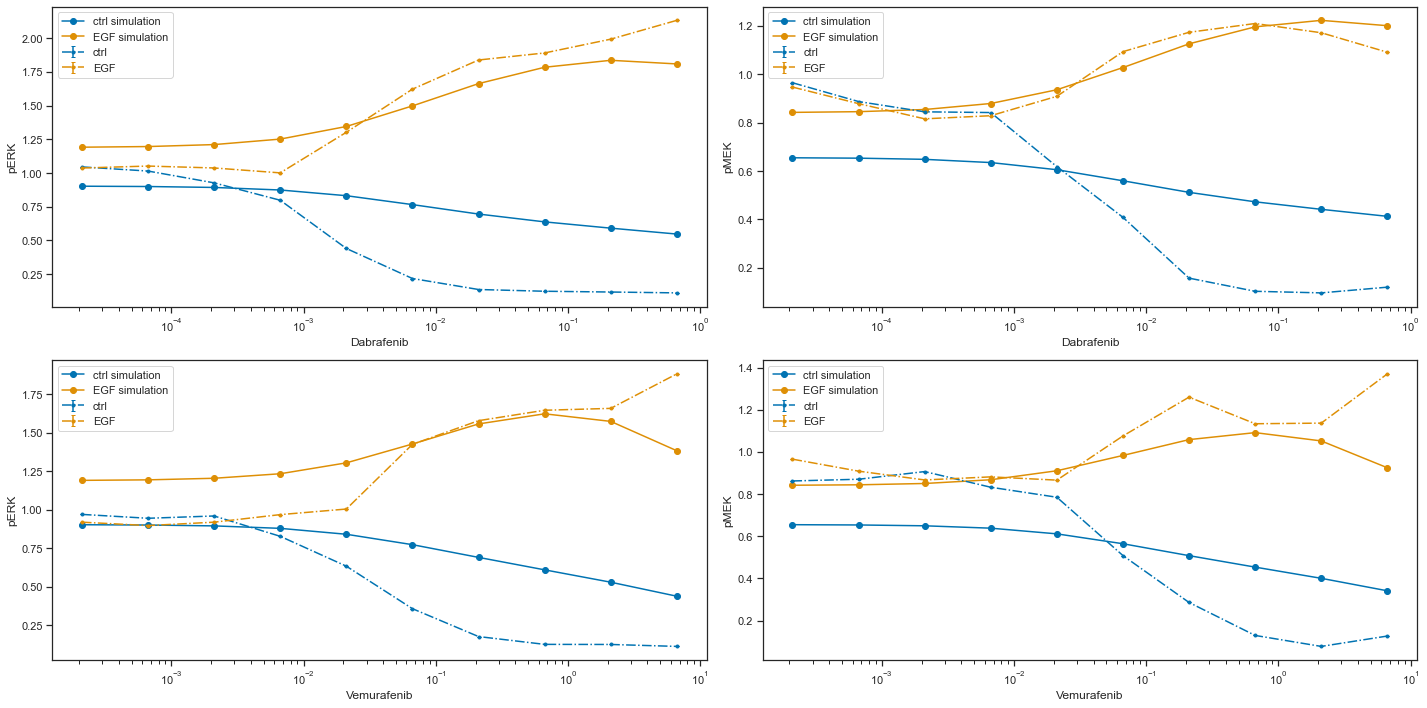

In [34]:
import petab.visualize
petab.visualize.plot_data_and_simulation(
    exp_data=measurement_table,
    exp_conditions=condition_table,
    sim_data=simulation_df,
    vis_spec=visualization_table
);

The visualization suggests, that model simulations take values that are similar to the data they still show qualitatively different behaviour. This suggests that the calibrated parameter values are an adequate first guess,  that this is an adequate starting point for further refinement.

Before we proceed with the second calibration round, we can check the accuracy of the objective function gradient at the pre-calibrated parameter values. For this purpose, we use the [`check_grad_multi_eps`](https://pypesto.readthedocs.io/en/latest/api_objective.html#pypesto.objective.ObjectiveBase.check_grad_multi_eps) method, which approximates the objective function gradient using finite differences with different step sizes.

In [41]:
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 8)
obj.x_names = [pypesto_problem.objective.x_names[ix] for ix in pypesto_problem.x_free_indices]
obj.check_grad_multi_eps(x, multi_eps=[1e-1, 1e-3, 1e-5], verbosity=0)

IndexError: list index out of range

The method computes forward (`fd_c`), backward (`fd_b`) and central (`fd_c`) finite differences and compares them to the sensitivity based gradient (`grad`), using the  step size `eps` that yields the lowest finite difference approximation error among the provided step sizes. The results show a low error in the finite difference approximation (`fd_err`), indicating accurate evaluation of the objective function. Moreover, the small absolute (`abs_err`) and relative difference (`rel_err`) between sensitivity based gradient and finite difference approximation indicates accurate evaluation of the gradient. The large magnitude of the gradient suggest that we did not yet reach a local optimum and that further optimization will likely improve agreement between data and simulation.

We will now perfom this refinement by instantiating a new optimizer with a larger computational budget of one hour.

In [36]:
optimizer_fine = FidesOptimizer(options={fides.Options.MAXTIME: 7200,
                                         fides.Options.SUBSPACE_DIM: fides.SubSpaceDim.TWO},
                                verbose=logging.ERROR)

To initialize the second calibration round at the pre-calibrated parameter values, we extract the respective values from the results object and set them as guesses in the pypesto problem.

In [37]:
n_refine = 10
pypesto_problem.x_guesses_full = np.vstack(result.optimize_result.get_for_key('x')[:n_refine])

For startpoint generation, pypesto will first start optimization runs at the provided parameter guesses and only sample new startpoint if more optimization runs than guesses are requested. As for the first calibration run, we run the calibration, again using the pyPESTO [`minimize`](https://pypesto.readthedocs.io/en/latest/api_optimize.html#pypesto.optimize.minimize) function.

In [38]:
result_refined = minimize(
    pypesto_problem, optimizer_fine, n_starts=n_refine,
    engine=pypesto.engine.MultiThreadEngine(4),
    progress_bar=False,
)

Performing parallel task execution on 4 threads.
Executing task 0.
Executing task 1.
Executing task 2.
Executing task 3.
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
Error occurred in:
0          0x12966d4b1 amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 497
1          0x12964eeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 241
2          0x12964fd48 .omp_outlined. + 488
3          0x12992ed23 __kmp_invoke_microtask + 147
4          0x1298ec376 __kmp_fork_call + 4523
5          0x1298e14d7 __kmpc_fork_call + 299
6          0x12964f850 amici::runAmiciSimulations(amici::Solver
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
Error occurred in:
0          0x12966d4b1 amici::SteadystateProble

[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
Error occurred in:
0          0x12966d4b1 amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 497
1          0x12964eeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 241
2          0x12964fd48 .omp_outlined. + 488
3          0x12992ed23 __kmp_invoke_microtask + 147
4          0x1298ec376 __kmp_fork_call + 4523
5          0x1298e14d7 __kmpc_fork_call + 299
6          0x12964f850 amici::runAmiciSimulations(amici::Solver
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
Error occurred in:
0          0x12966d4b1 amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 497
1          0x12964eeb1 amici::AmiciApplication::runAm

[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
Error occurred in:
0          0x12966d4b1 amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 497
1          0x12964eeb1 amici::AmiciApplication::runAmiciSimulation(amici::Solver&, amici::ExpData const*, amici::Model&, bool) + 241
2          0x12964fd48 .omp_outlined. + 488
3          0x12992ed23 __kmp_invoke_microtask + 147
4          0x1298ec376 __kmp_fork_call + 4523
5          0x1298e14d7 __kmpc_fork_call + 299
6          0x12964f850 amici::runAmiciSimulations(amici::Solver
[Warning] AMICI:simulation: AMICI simulation failed:
Steady state sensitivity computation failed due to unsuccessful factorization of RHS Jacobian
Error occurred in:
0          0x12966d4b1 amici::SteadystateProblem::workSteadyStateProblem(amici::Solver*, amici::Model*, int) + 497
1          0x12964eeb1 amici::AmiciApplication::runAm

As for the pre-calibration, we now visualize the results using `petab` and the previously constructed visualization table.

Using existing amici model in folder /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/amici_models/thermo_raf.


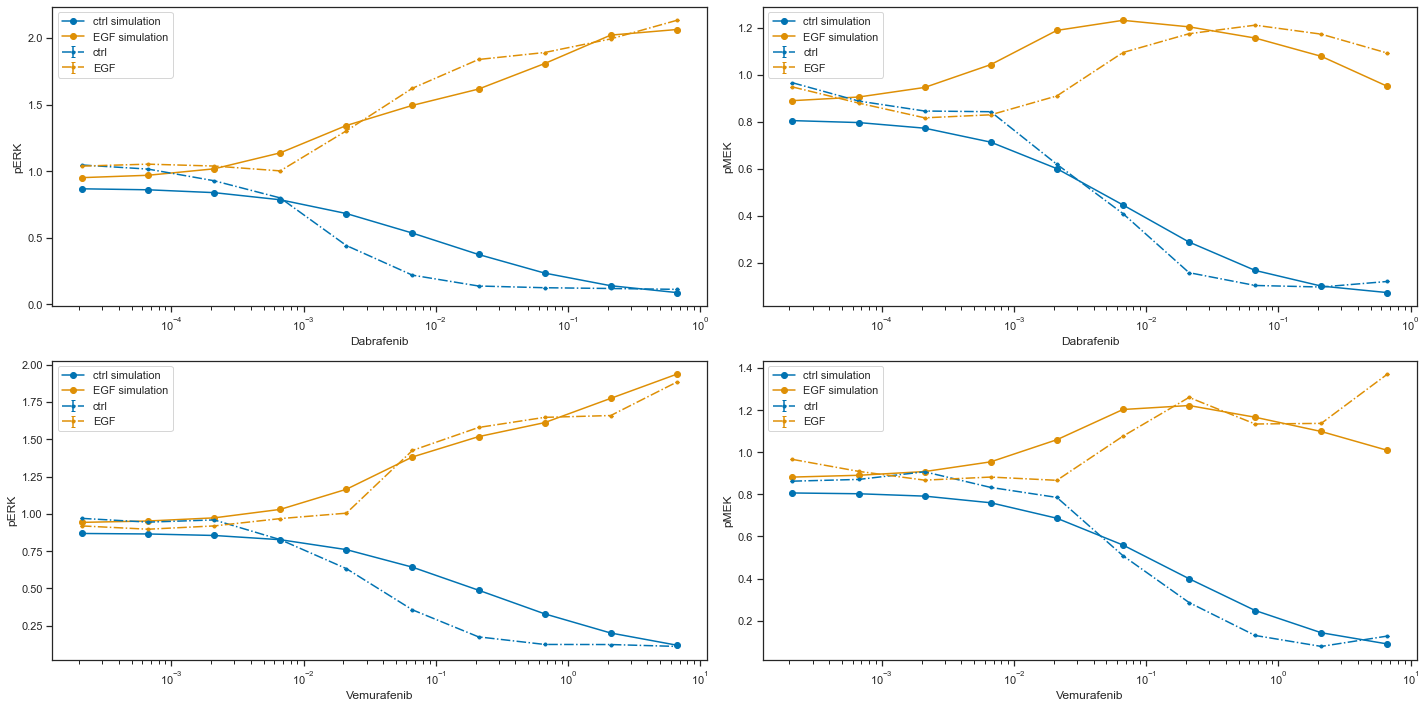

In [39]:
x = pypesto_problem.get_reduced_vector(
    result_refined.optimize_result.list[0]['x'],
    pypesto_problem.x_free_indices
)
simulation = pypesto_problem.objective(x, return_dict=True)
simulation_df = amici.petab_objective.rdatas_to_simulation_df(
    simulation['rdatas'],
    model=importer.create_model(),
    measurement_df=measurement_table,
)

simulation_df = simulation_df.sort_values([
    petab.OBSERVABLE_ID, petab.PREEQUILIBRATION_CONDITION_ID, petab.SIMULATION_CONDITION_ID
]).reset_index()
measurement_table = measurement_table.sort_values([
    petab.OBSERVABLE_ID, petab.PREEQUILIBRATION_CONDITION_ID, petab.SIMULATION_CONDITION_ID
]).reset_index()

petab.visualize.plot_data_and_simulation(
    exp_data=measurement_table,
    exp_conditions=condition_table,
    sim_data=simulation_df,
    vis_spec=visualization_table
);

These plots now indicate good agreement between experimental data and model simulations. As a last step of the analysis, we now compare the objective function values across both calibration rounds using a waterfall plot.

[WARNING] /Users/ffroehlich/Documents/HMS/energy_modeling_chapter/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



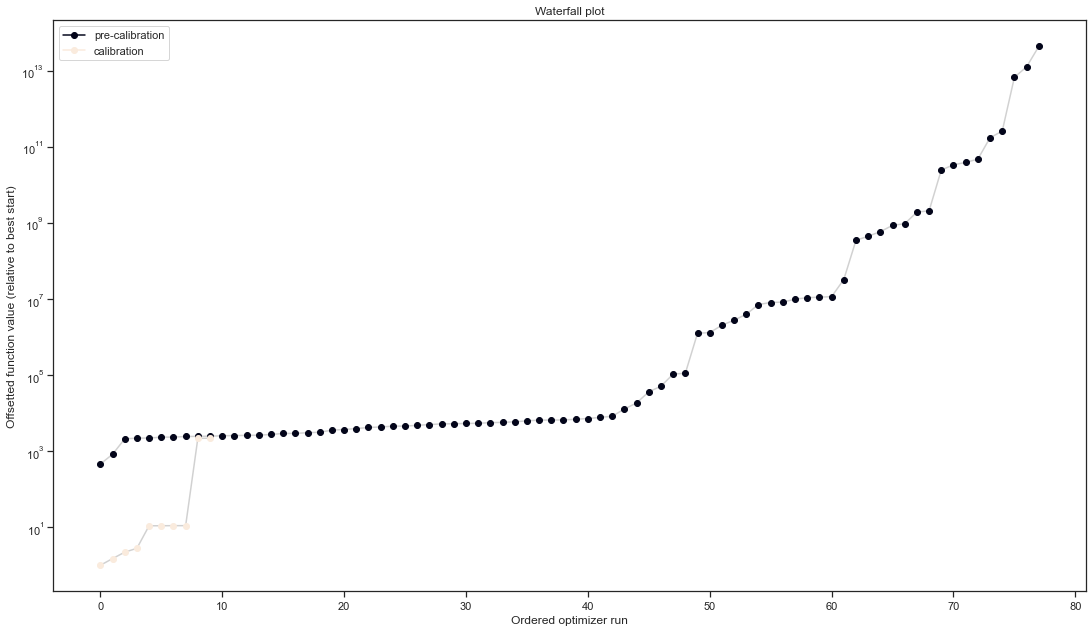

In [40]:
from pypesto.visualize import waterfall
waterfall(results=[result,result_refined],
          legends=['pre-calibration', 'calibration']);

The waterfall plot shows sorted objective function values of different optimizer runs for pre-calibration and calibration. The objective function values are normalized to the best objective function value achieved across both runs. We observe that for the majority of fully calibrated runs, we achieve much lower objective function values compared to the pre-calibrated runs, indicating that the higher computational budget facilitated a better fits. For a small subset of starts, we observe repeated convergence to similar objective function values that form a plateau in the waterfall plots, suggesting that the respective runs may have converged to the same local minimum. Ideally, the majority of objective function values would lie in a plateau, but this would likely require many more optimizer runs with larger computational budgets and would thus have to be performed on a computer cluster.

# Discussion

Even with state-of-the-art methods the process of model formulation, problem specification and calibration we described in this manuscript remains a labour intensive process, where good understanding of the underlying mathemical concepts is necessary to achieve optimal, or even adequate performance for large kinetic models. We anticipate that the extensive description and code we provide in this protocol will serve as an introduction to model calibration and may be used as template for future research projects. 

In terms of future developments, more automation in terms of tolerance selection, sensitivity methods and computational budget allocation will be necessary to improve accessibility of methods and reduce user interaction. Some frameworks such as data2dynamics <cite data-cite="2754712/RYRYBYZA"></cite> already provide adaptive tolerance updating schemes in cases of numerical integration failure. This could still be complemented by adaptive updating of tolerances based on objective function evaluation accuracy, but underlying mathematical theory and good benchmark problems are missing. We are convinced that the introduction of large benchmarks in <cite data-cite="2754712/FMD3RVCR"></cite> <cite data-cite="2754712/INKV577L"></cite>, guidelines for their evaluation <cite data-cite="2754712/NYMSV8TA"></cite> as well as the standardization of their formulation <cite data-cite="2754712/86CV69R2"></cite> will be crucial to improve automation of model calibration.

## References
<div class="cite2c-biblio"></div>